# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import config

# supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import importlib
import utils.visualisation
import utils.feature_engineering

# reload custom libraries without restarting Kernel
importlib.reload(utils.visualisation)
importlib.reload(utils.feature_engineering)

from utils.visualisation import display_df, summarize_df
from utils.visualisation import plot_target_distribution, plot_categorical_vs_target, plot_numerical_distributions, plot_boxplots_by_target, plot_correlation_heatmap
from utils.feature_engineering import calculate_rare_categories, normalize_rare_categories

### Load and preview the data

We load the cleaned dataset saved after feature engineering and missing value imputation.


In [3]:
# Load cleaned data
df = pd.read_pickle(config.RESULTS_PATH+"titanic_clean.pkl")

# Quick overview
display_df(df)
summarize_df(df, mode="basic")

# categorical and numerical features:

# Name, Ticket - is removed
categorical_features = [
    'Sex', 'Embarked', 'Title',
    'Deck', 'AgeGroup', 'TicketPrefix'
]
# PassengerId - is removed
numerical_features = [
    'Pclass', 'Age', 'SibSp', 'Parch',
    'Fare', 'FamilySize', 'IsAlone', 'FareBand'
]

target = config.TARGET_NAME

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Title,FamilySize,IsAlone,Deck,AgeGroup,Fare,FareBand,TicketPrefix
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,S,Mr,2,0,Unknown,young,7.25,0.0,A/5
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,C,Mrs,2,0,C,adult,70.00,50.0,PC
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,S,Miss,1,1,Unknown,young,7.90,7.5,Other
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,S,Mrs,2,0,C,adult,50.00,25.0,
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,S,Mr,1,1,Unknown,adult,8.05,7.5,
6,0,3,"Moran, Mr. James",male,30.0,0,0,330877,Q,Mr,1,1,Unknown,young,8.45,7.5,
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,S,Mr,1,1,E,adult,50.00,25.0,
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,S,Master,5,0,Unknown,kids<3,20.00,15.0,
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,S,Mrs,3,0,Unknown,young,11.00,7.5,
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,C,Mrs,2,0,Unknown,teenager,30.00,25.0,



========== Dataset Summary ==========

Shape: 891 rows × 18 columns

🧾 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   891 non-null    int64   
 1   Survived      891 non-null    int64   
 2   Pclass        891 non-null    int64   
 3   Name          891 non-null    object  
 4   Sex           891 non-null    object  
 5   Age           891 non-null    float64 
 6   SibSp         891 non-null    int64   
 7   Parch         891 non-null    int64   
 8   Ticket        891 non-null    object  
 9   Embarked      891 non-null    object  
 10  Title         891 non-null    object  
 11  FamilySize    891 non-null    int64   
 12  IsAlone       891 non-null    int64   
 13  Deck          891 non-null    object  
 14  AgeGroup      891 non-null    category
 15  Fare          891 non-null    float64 
 16  FareBand  

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Title,FamilySize,IsAlone,Deck,AgeGroup,Fare,FareBand,TicketPrefix
count,891.00,891.00,891.00,891,891,891.00,891.00,891.00,891,891,891,891.00,891.00,891,891,891.00,891.00,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,3,9,NaN,NaN,7,7,NaN,NaN,6
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,S,Mr,NaN,NaN,Unknown,young,NaN,NaN,
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,646,517,NaN,NaN,687,521,NaN,NaN,661
mean,446.00,0.38,2.31,NaN,NaN,29.41,0.52,0.38,NaN,NaN,NaN,1.90,0.60,NaN,NaN,32.10,17.29,NaN
std,257.35,0.49,0.84,NaN,NaN,13.25,1.10,0.81,NaN,NaN,NaN,1.61,0.49,NaN,NaN,49.52,15.78,NaN
min,1.00,0.00,1.00,NaN,NaN,0.42,0.00,0.00,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,0.00,NaN
25%,223.50,0.00,2.00,NaN,NaN,21.50,0.00,0.00,NaN,NaN,NaN,1.00,0.00,NaN,NaN,7.90,7.50,NaN
50%,446.00,0.00,3.00,NaN,NaN,30.00,0.00,0.00,NaN,NaN,NaN,1.00,1.00,NaN,NaN,14.50,7.50,NaN
75%,668.50,1.00,3.00,NaN,NaN,35.00,1.00,0.00,NaN,NaN,NaN,2.00,1.00,NaN,NaN,30.00,25.00,NaN



❓ Missing Values:
✅ No missing values.

🔁 Duplicated rows: 0



### Target variable distribution

We examine the distribution of the target variable `Survived` to understand class balance.


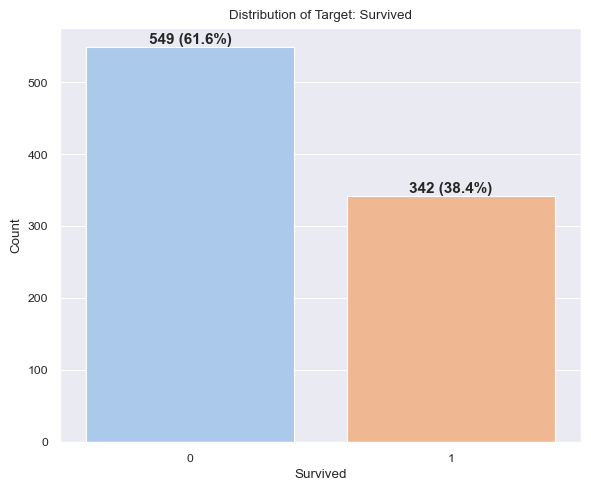

In [4]:
plot_target_distribution(df, target)

We observe that the target variable `Survived` is moderately imbalanced:
- 549 passengers (61.6%) did **not** survive
- 342 passengers (38.4%) **survived**

This imbalance is important to consider when selecting and evaluating models.


### Categorical features vs Survival

We explore how survival varies across categories like Sex, Pclass, Title, IsAlone, AgeGroup, and more.


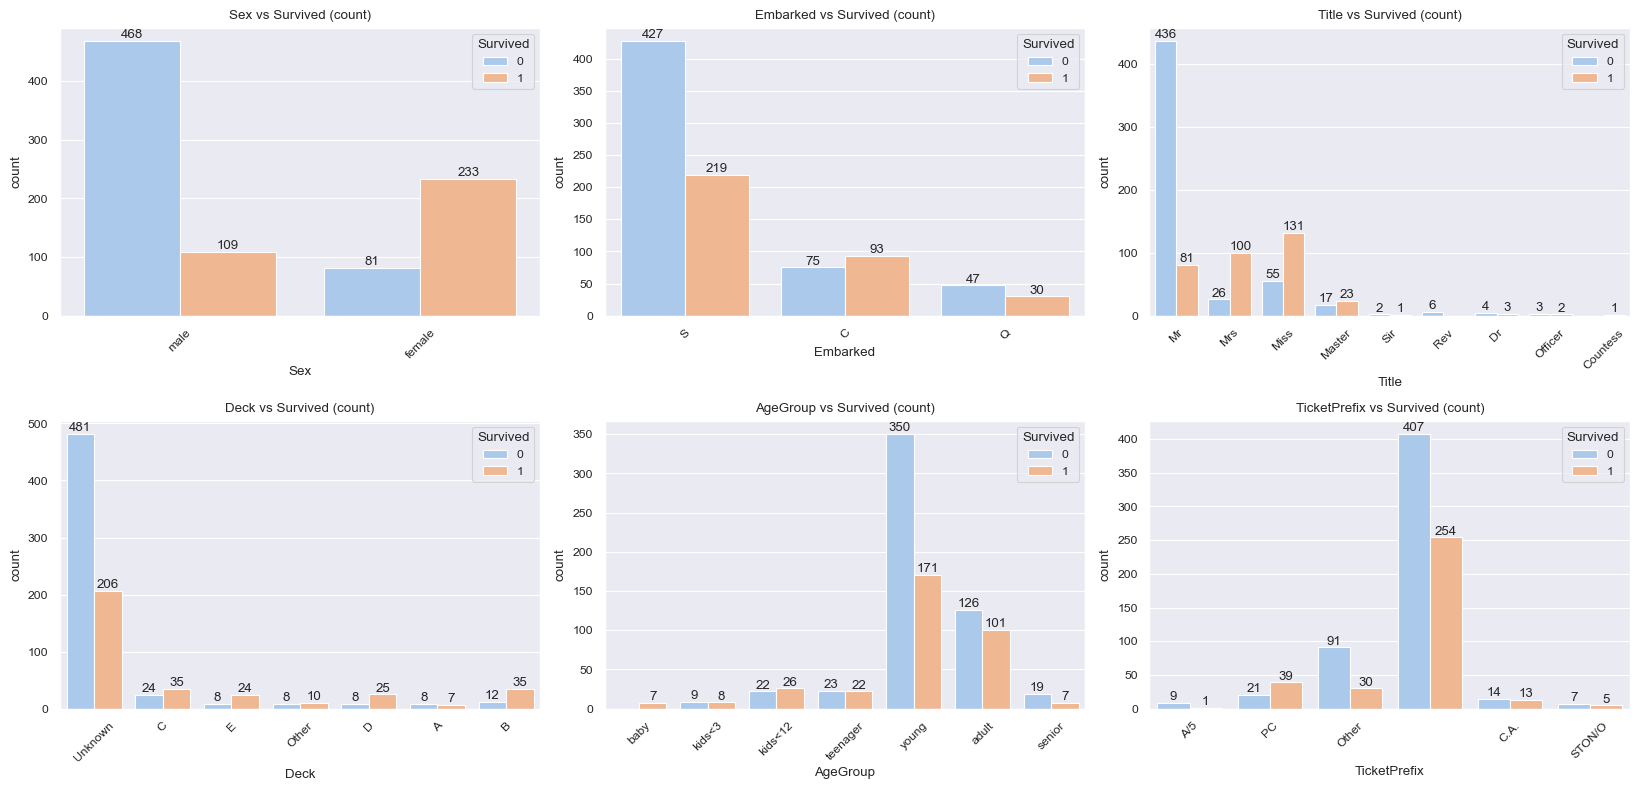

In [5]:
plot_categorical_vs_target(df, categorical_features, target=target, mode="count")

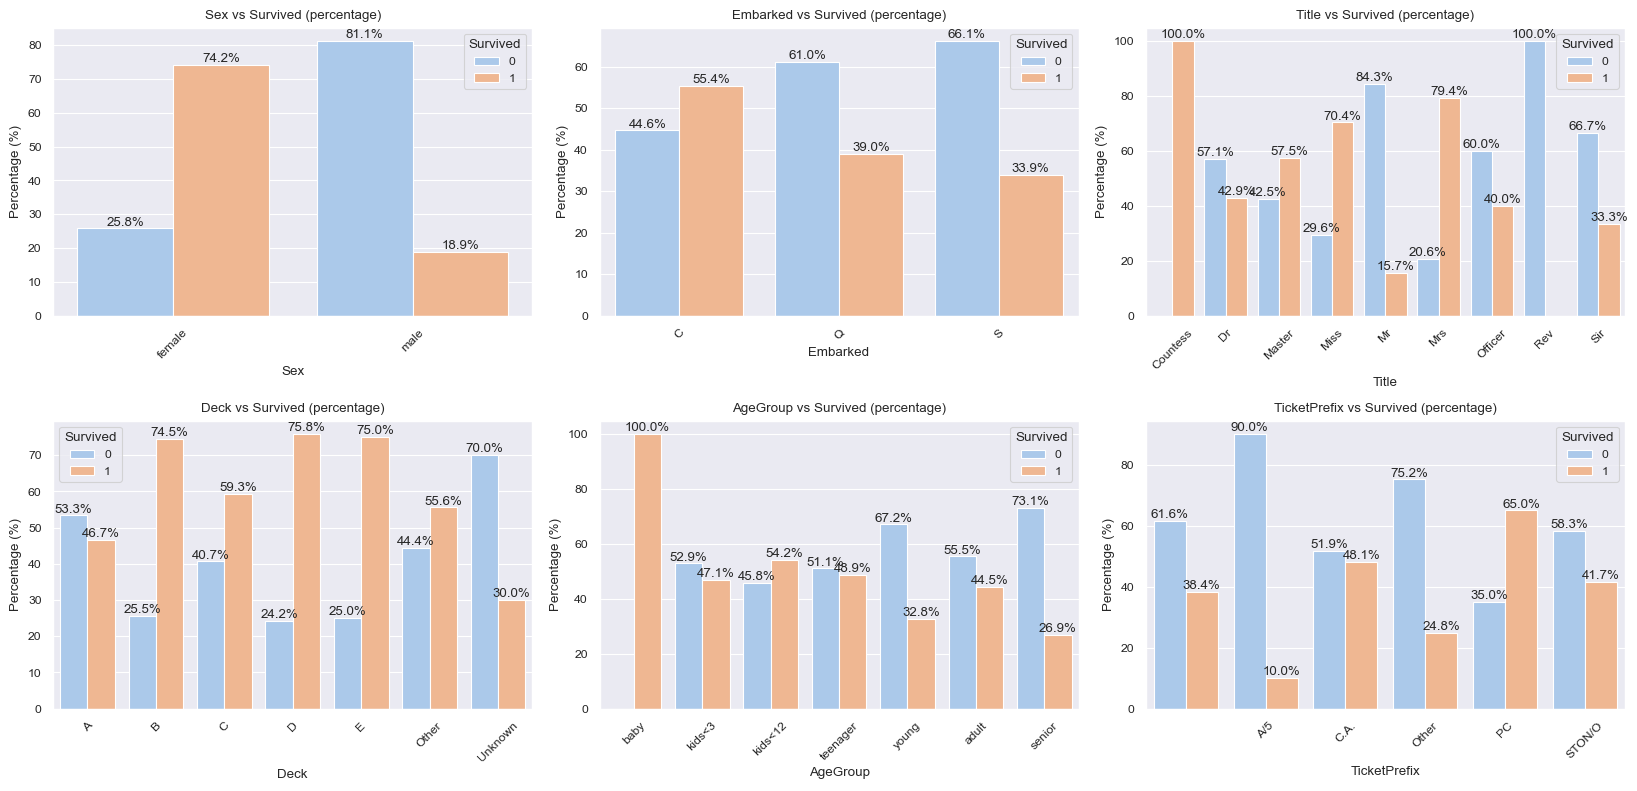

In [6]:
plot_categorical_vs_target(df, categorical_features, target=target, mode="percentage")

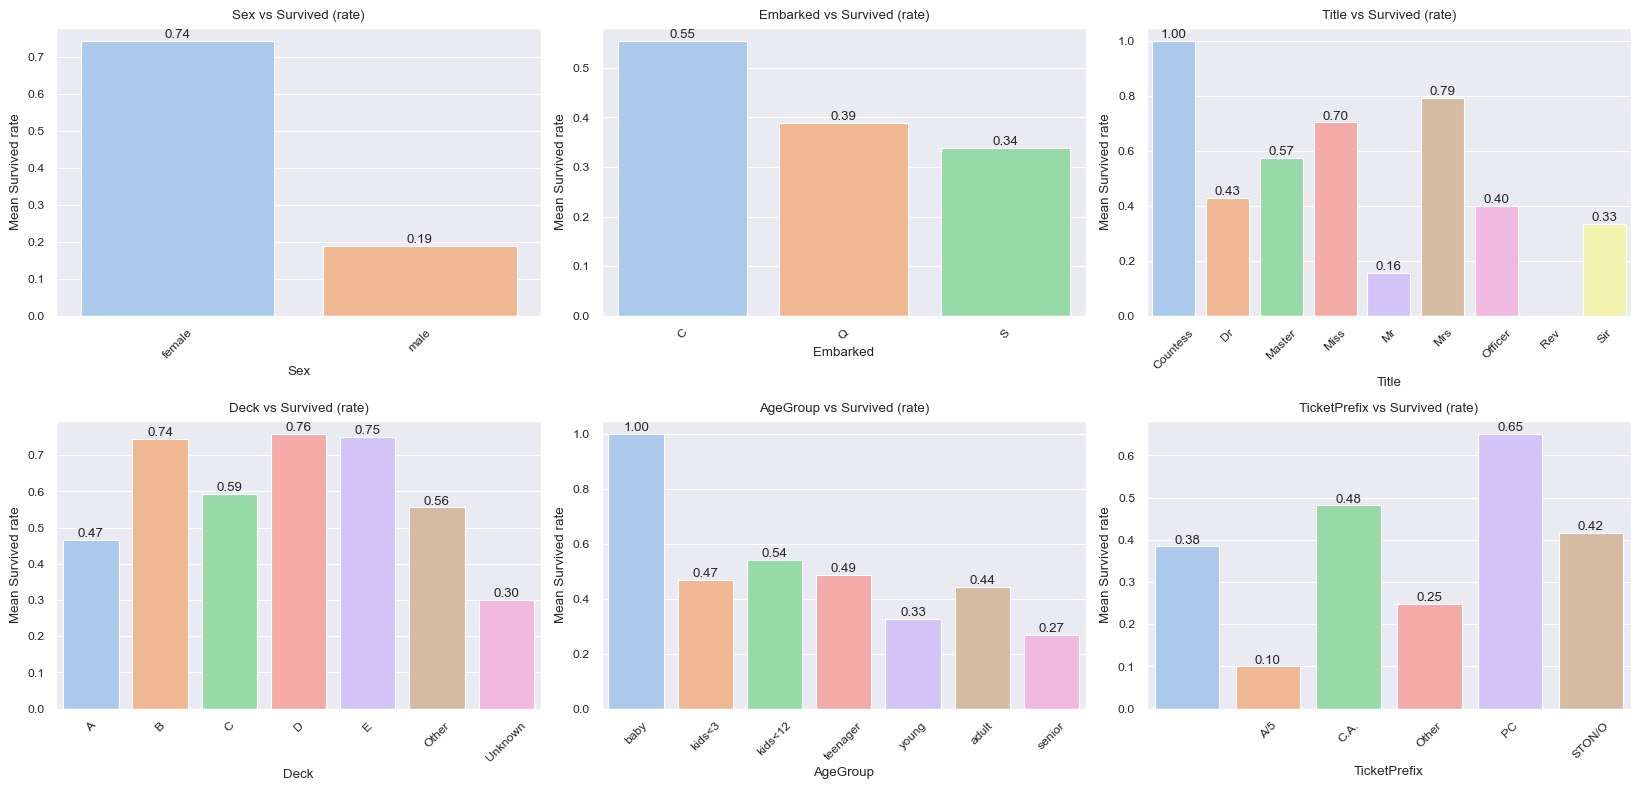

In [7]:
plot_categorical_vs_target(df, categorical_features, target=target, mode="rate")

- Women had a much higher survival rate than men.
- Passengers with titles like "Miss" and "Mrs" had better survival odds.
- Decks C, E, and B had higher survival proportions, while "Unknown" had the lowest.


In [8]:
rare_summary_df = calculate_rare_categories(df, categorical_features=categorical_features)

display_df(rare_summary_df)

Feature,Rare Count,Rare Values
Title,6,"Master (40), Dr (7), Rev (6), Officer (5), Sir (3), Countess (1)"
Deck,4,"D (33), E (32), Other (18), A (15)"
AgeGroup,3,"senior (26), kids<3 (17), baby (7)"
TicketPrefix,3,"C.A. (27), STON/O (12), A/5 (10)"


### Analysis of Rare Categories

To ensure our model generalizes well and doesn't overfit on rare or noisy categories, we identified feature values with low frequency (less than 5% of all records). The summary shows which features contain rare categories and how many such values were found.

**Key observations:**

* **Title** contains several rare values like `Master`, `Dr`, `Rev`, `Officer`, `Sir`, and `Countess`, each with low counts. Most of them can be safely grouped as "Other".
* **Deck** has highly imbalanced categories, with `Unknown` dominating the rest. The values `D`, `E`, `Other`, and `A` fall below the threshold and may be grouped or dropped.
* **AgeGroup** contains rare categories like `senior`, `kids<3`, and `baby`, each appearing in less than 5% of the data. We may consider combining child-related groups or simplifying them further.
* **TicketPrefix** has sparse and inconsistent categories. Prefixes like `C.A.`, `STON/O`, and `A/5` are rare and may be aggregated under "Other" or dropped altogether.

**Next steps:**

* Decide which rare categories should be **merged** into "Other" and which **features should be dropped** from modeling due to lack of useful signal.
* Update feature engineering functions accordingly (e.g., `normalize_rare_categories()`).
* Document and apply these transformations consistently during both training and inference.


### Numerical feature distributions

We analyze distributions of Age, Fare, and FamilySize using histograms and KDE plots.


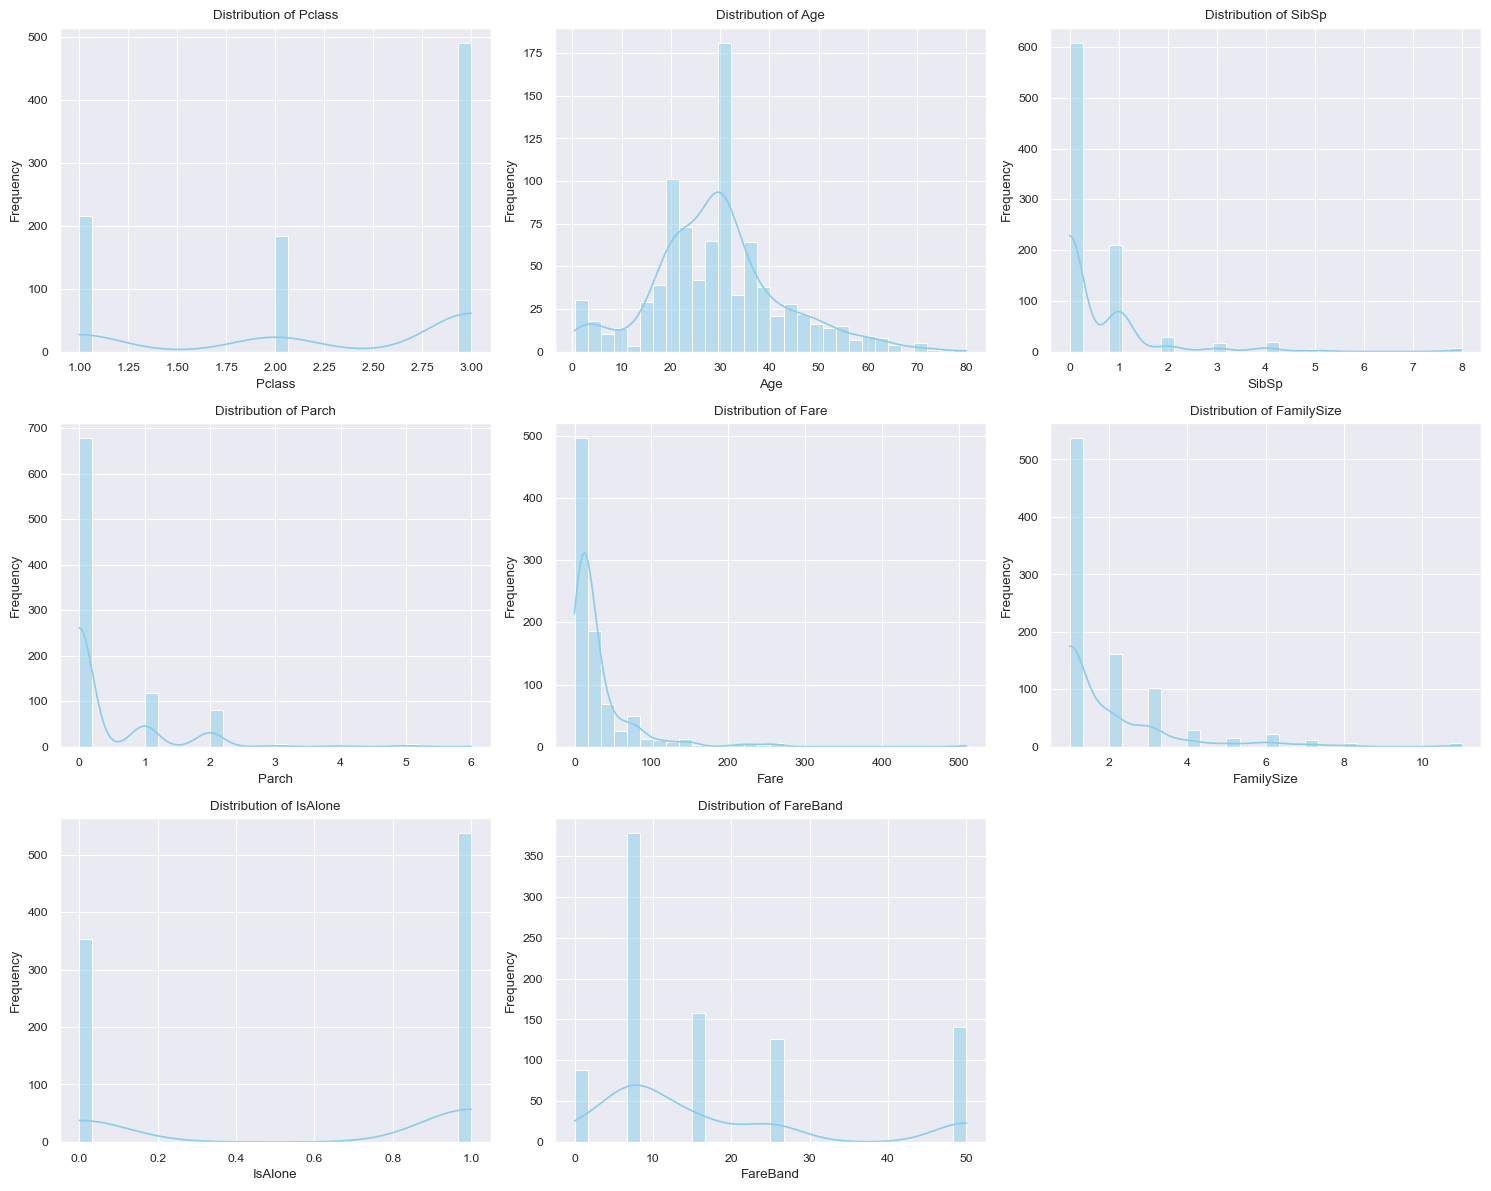

In [9]:
plot_numerical_distributions(df, features=numerical_features)

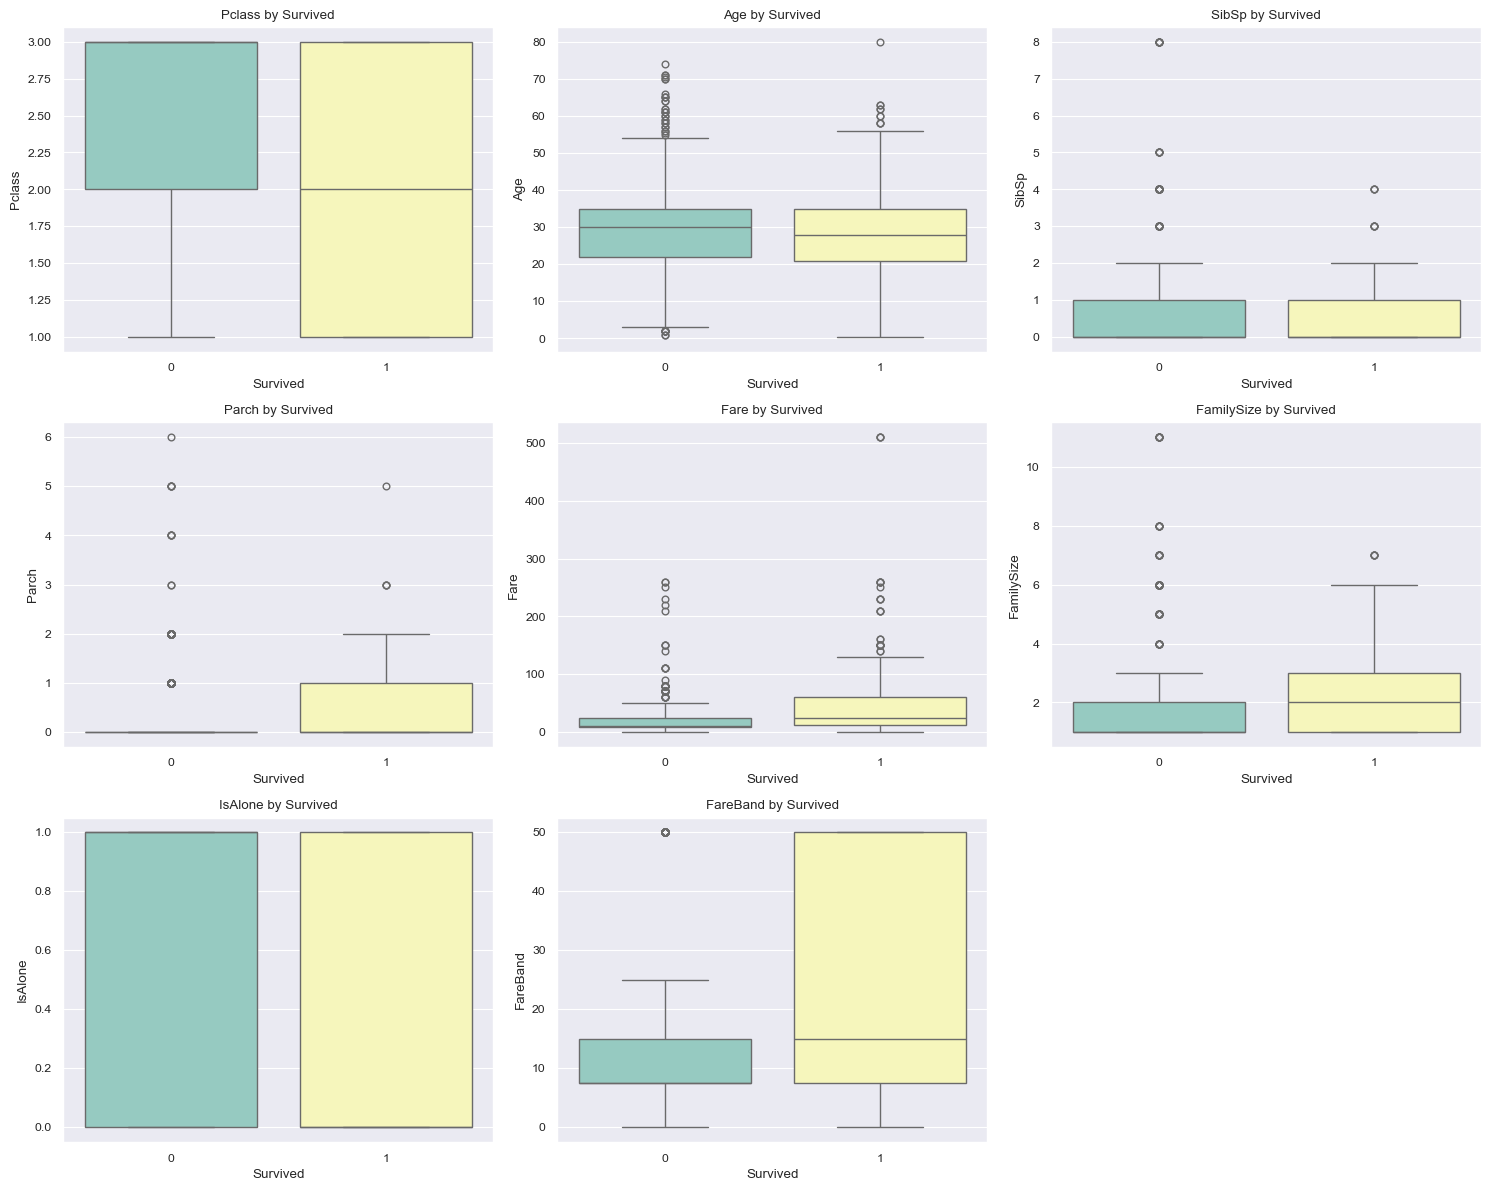

In [10]:
plot_boxplots_by_target(df, features=numerical_features, target=target)

### Analysis Summary: Numerical Feature Distributions and Target Relationship

We analyzed the numerical features in the Titanic dataset using both distribution plots and boxplots segmented by the target variable `Survived`. Below are the key observations:

---

#### General Distributions (Histogram + KDE)

* **Pclass**: Discrete feature with clear class imbalance. Majority of passengers were in 3rd class.
* **Age**: Right-skewed distribution. Majority of passengers are between 20 and 40 years old.
* **SibSp / Parch**: Extremely right-skewed, with most passengers having 0 or 1 relatives aboard. Higher values are rare and may be grouped.
* **Fare / FareRounded**: Very long right tail, with some extremely high outliers. Log transformation could be considered.
* **FamilySize**: Similar pattern to `SibSp` and `Parch`. Most passengers traveled in small family groups.
* **IsAlone**: Binary feature. Majority of passengers were traveling alone.
* **FareBand**: Custom-binned fare variable, now treated as numerical. Mostly balanced, useful for segmentation.

---

#### Boxplots vs `Survived`

* **Pclass**: Clear difference. Passengers in 1st class had higher survival rates.
* **Age**: Slight age shift toward younger survivors. But overall, variance is large.
* **SibSp / Parch / FamilySize**: Survivors tend to have slightly larger families. Still many outliers.
* **Fare / FareRounded / FareBand**: Strong positive correlation with survival. Survivors generally paid higher fares.
* **IsAlone**: Slight survival advantage for those not alone.

---

### Conclusions & Next Steps

* **Outliers**: Consider handling extreme values in `Fare`, `FamilySize`, and `Parch`.
* **Transformations**: Skewed distributions like `Fare` may benefit from normalization or log-scaling.
* **Grouping**: Values above a threshold in `FamilySize`, `Parch`, or `SibSp` can be grouped into a single "Large" category.
* **Feature Utility**: `Pclass`, `Fare`, and `FamilySize` show strong separation between survival classes and are likely important.

Next, we will proceed to analyze correlations among features.


### Correlation heatmap

Visualizing pairwise correlations between numerical features and target.


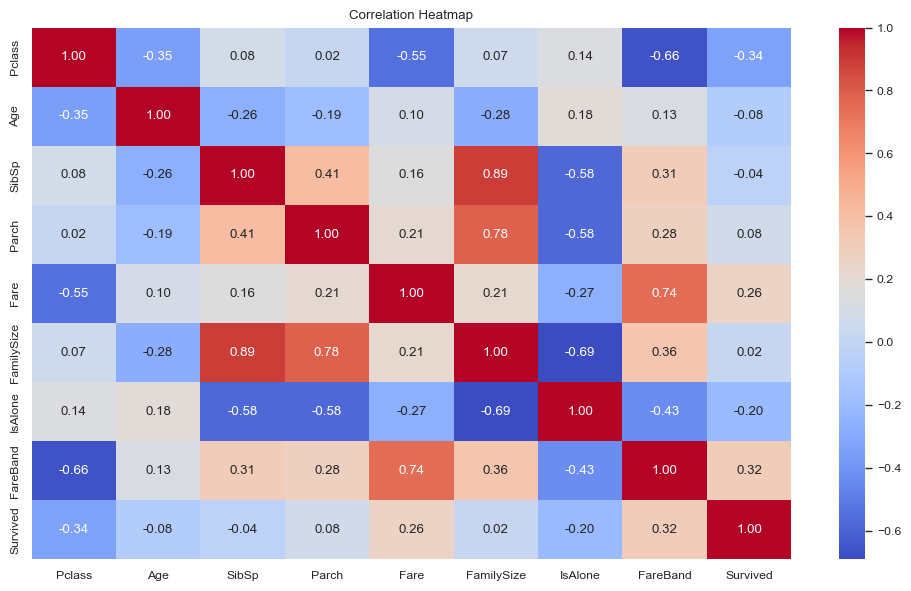

In [11]:
plot_correlation_heatmap(df, features=numerical_features, target=target)

### Correlation Analysis – Summary & Observations

1. **Strong Feature Redundancy**

   * `Fare`, `FareRounded`, and `FareBand` show very high pairwise correlations (\~0.74).
     ✉️ *Consider keeping only one of them (e.g., `FareBand`, as it’s binned and easier to interpret).*

   * `FamilySize` shows high correlation with both `SibSp` (0.89) and `Parch` (0.78).
     ✉️ *Keeping `FamilySize` might be sufficient; `SibSp` and `Parch` could be excluded.*

2. **Inversely Correlated Features**

   * `Pclass` is negatively correlated with `Fare` and its derivatives (\~-0.55 to -0.66).
     ✉️ *These features may encode overlapping information about socio-economic status.*

3. **Target Feature (`Survived`) Correlations**

   * Moderate correlation:

     * `FareBand` → 0.32
     * `Fare` → 0.26
     * `FareRounded` → 0.26
   * Weak/negative correlation:

     * `IsAlone` → -0.20
     * `Pclass` → -0.34

     ✉️ *Although correlations with the target are not strong, `Fare`, `FareBand`, `IsAlone`, and `Pclass` still provide signal and are worth keeping.*

4. **Uninformative Features**

   * `Age`, `SibSp`, `Parch`, `FamilySize` — all show very weak correlation with `Survived`.
     ✉️ *May still be useful for non-linear models, so don’t remove immediately, but track their contribution during model training.*


### Final Data Preparation Summary

Before proceeding to model training, we finalize the dataset by normalizing rare categorical values and saving the processed file.

#### Key Actions:
- **Collapsed rare categories** to avoid overfitting and data sparsity in:
  - `Title` → rare titles grouped as `"Other"` (min_count = 10)
  - `Deck` → decks with fewer than 15 entries grouped as `"Other"`
  - `TicketPrefix` → kept only top 5 frequent prefixes, others grouped as `"Other"`

#### Saved Files:
- `titanic_ready.pkl` — binary format for model training (keeps data types)
- `titanic_ready.csv` — CSV format for inspection and sharing

These datasets will be used for all further training and validation.  
No further preprocessing will be done during modeling — the data is now ready.

*Clean, reduced noise, and aligned with our EDA insights.*


In [12]:
# Collapse rare categories
df = normalize_rare_categories(df, col="Title", min_count=10)
df = normalize_rare_categories(df, col="Deck", min_count=15)
df = normalize_rare_categories(df, col="TicketPrefix", top_n=5)
# (Optionally: AgeGroup)

# Save cleaned version for modeling
df.to_pickle(config.RESULTS_PATH + "titanic_ready.pkl")
df.to_csv(config.RESULTS_PATH + "titanic_ready.csv", index=False)
print("✅ Cleaned dataset saved for model training.")

🔁 Title: Replaced 5 rare categories with 'Other': ['Countess', 'Dr', 'Officer', 'Rev', 'Sir']
🔁 Deck: Replaced 0 rare categories with 'Other': []
🔁 TicketPrefix: Replaced 1 rare categories with 'Other': ['A/5']
✅ Cleaned dataset saved for model training.
